In [1]:
#!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df=pd.read_csv("C:\\Users\\kshit\\OneDrive\\Desktop\\Machine Learning\\Twitter_Toxicity\\train.csv")

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
from tensorflow.keras.layers import TextVectorization


In [6]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [7]:
# words in vocab
MAX_FEATURES = 200000

In [8]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [9]:
vectorizer.adapt(X.values)

In [10]:
vectorized_text = vectorizer(X.values)

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000) #160000 buffer size
dataset = dataset.batch(16)       # 16 SAMPLES
dataset = dataset.prefetch(8)     # HELPS BOTTLENECKS

In [12]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [14]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(6, activation='sigmoid'))

In [15]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [17]:
history = model.fit(train, epochs=10, validation_data=val)


6981/6981 [==============================] - 2334s 333ms/step - loss: 0.0623 - val_loss: 0.0452


In [18]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

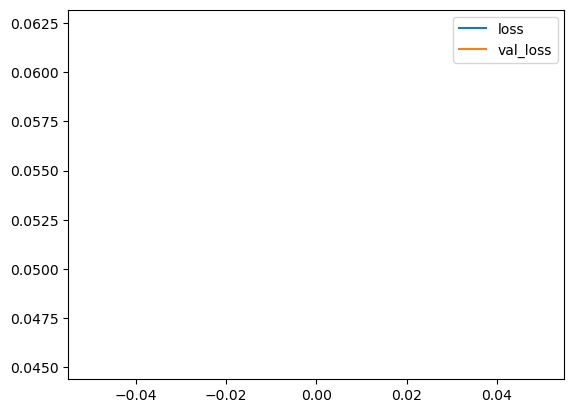

In [19]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Prediction

In [20]:
input_text = vectorizer('You freaking suck! I am going to punish you.')
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7113,  396, ...,    0,    0,    0], dtype=int64)>

In [21]:
res = model.predict(np.expand_dims(input_text,0))
res

1/1 [==============================] - 1s 1s/step


array([[0.98066115, 0.07102913, 0.8771087 , 0.0363364 , 0.69432837,
        0.07724613]], dtype=float32)

In [22]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [23]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [24]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 131ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [25]:
res.shape

(1, 6)

# Evaluation

In [26]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [27]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [28]:
for batch in test.as_numpy_iterator(): 
    X_true, y_true = batch
    yhat = model.predict(X_true)
    
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 150ms/step


In [29]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7786523699760437, Recall:0.7237342596054077, Accuracy:0.4653961956501007


In [30]:
!pip install typing-extensions 3.7.4

ERROR: Could not find a version that satisfies the requirement 3.7.4
ERROR: No matching distribution found for 3.7.4


In [31]:
#!pip install gradio

In [1]:
import tensorflow as tf
import gradio as gr
import pickle 

In [ ]:
with open('model.pkl','wb') as f:
    pickle.dump(clf,f)

In [33]:
model.save('toxicity.h5')

In [34]:
model = tf.keras.models.load_model('toxicity.h5')

In [36]:
input_str = vectorizer('hey i freaken hate you!')

In [37]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 1s/step


In [38]:
res

array([[0.7668899 , 0.01372894, 0.3129928 , 0.02472473, 0.35423127,
        0.04528512]], dtype=float32)

In [39]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [40]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

C:\Users\kshit\OneDrive\Desktop\Machine Learning\facedet\lib\site-packages\gradio\inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\kshit\OneDrive\Desktop\Machine Learning\facedet\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\kshit\OneDrive\Desktop\Machine Learning\facedet\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\kshit\OneDrive\Desktop\Machine Learning\facedet\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [41]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://11518.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x1f64ac1cd00>,
 'http://127.0.0.1:7860/',
 'https://11518.gradio.app')

1/1 [==============================] - 0s 168ms/step
